## Shallow embeddings: ejemplo con Node2Vec

### Configuración general

In [48]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')
import numpy as np
import networkx as nx
from node2vec import Node2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
def plot_graph(g, comms, ax=None, pos=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(12,12))
        
    colors = np.zeros(g.number_of_nodes(), dtype='int')
    for comm, node in enumerate(comms):
        colors[node] = comm
    if pos is None:
        pos = nx.spring_layout(g, seed=22)
    nx.draw(
        g, with_labels=True, pos=pos, node_color=colors, cmap='Set2', 
        ax=ax
    )
    return ax

In [153]:
g = nx.karate_club_graph()
n = g.number_of_nodes()
print(nx.info(g))

Graph named "Zachary's Karate Club" with 34 nodes and 78 edges


In [4]:
membership = np.array([g.nodes[v]['club'] for v in g])
set(membership)

{'Mr. Hi', 'Officer'}

In [5]:
original_comms = [
    np.array(g.nodes())[membership=='Mr. Hi'].tolist(),
    np.array(g.nodes())[membership=='Officer'].tolist()
]
original_comms

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21],
 [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]

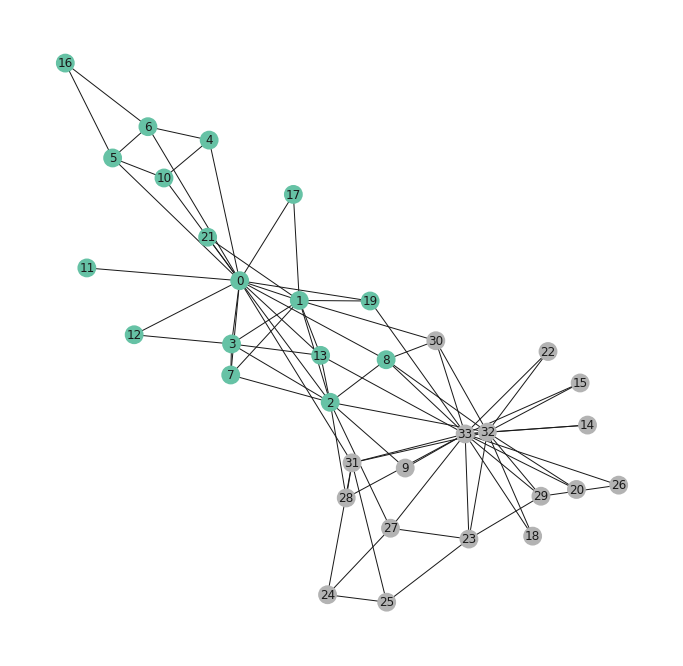

In [90]:
plot_graph(g, original_comms);

### Node2Vec

Construimos nuestro modelo `Node2Vec`.

Entrenar Node2Vec consta de dos etapas. 

**Primera etapa:** realizamos las caminatas aleatorias sobre el grafo para obtener nuestras secuencias de nodos.

**Segunda etapa:** interpretamos cada nodo como una palabra, y transformamos cada secuencia de palabras en un texto. Con este texto, entrenamos un modelo word2vec

In [135]:
## Primera etapa
dim = 50
node2vec = Node2Vec(g, dimensions=dim, walk_length=5, num_walks=100, p=1, q=1, seed=22)
type(node2vec)

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████| 100/100 [00:00<00:00, 1404.65it/s]


node2vec.node2vec.Node2Vec

In [136]:
## Segunda etapa
model = node2vec.fit(window=4)
type(model)

gensim.models.word2vec.Word2Vec

Al ajustar el modelo `Node2Vec`, obtenemos una instancia del modelo [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) de la librería `gensim`.

In [137]:
embedding = np.array([model.wv[str(idx)] for idx in g.nodes()])
embedding.shape

(34, 50)

In [138]:
model.wv.most_similar('16')

[('6', 0.9938026666641235),
 ('4', 0.9937502145767212),
 ('10', 0.993286669254303),
 ('5', 0.9925605654716492),
 ('0', 0.9772791862487793),
 ('11', 0.9706552028656006),
 ('12', 0.9670180082321167),
 ('21', 0.9644364714622498),
 ('17', 0.9630292057991028),
 ('1', 0.9604261517524719)]

#### **Visualización del embedding**

Aplicamos dos algoritmos de reducción de dimensionalidad para llevar el embedding a dos dimensiones

In [147]:
pca = PCA(n_components=2, random_state=22).fit_transform(embedding)
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=22).fit_transform(embedding)

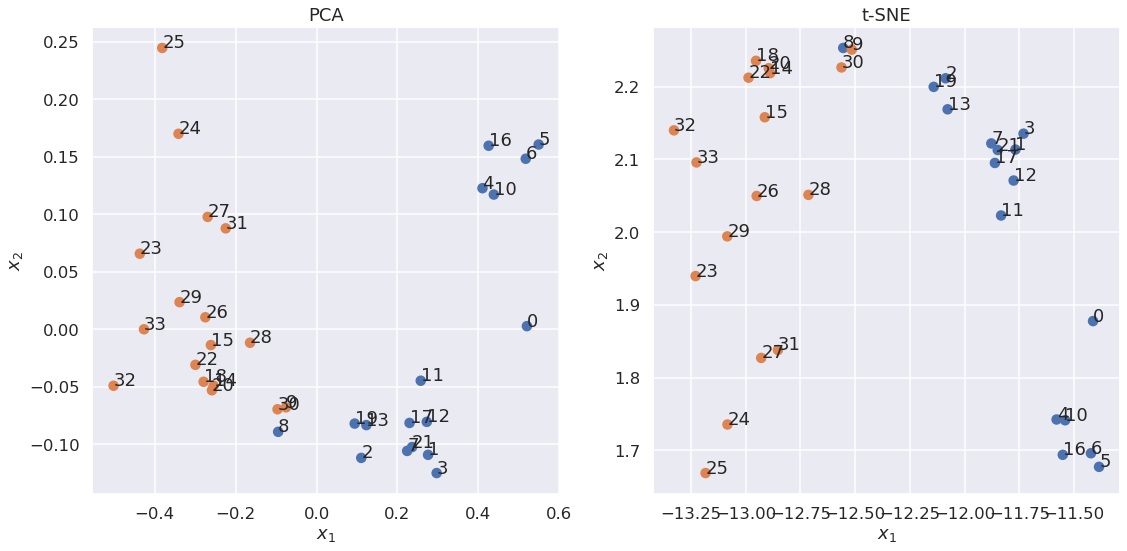

In [148]:
def add_labels(g, pos, ax):
    labels = [v for v in g.nodes()]
    for i in range(g.number_of_nodes()):
        x, y = pos[i]
        label = labels[i]
        ax.text(x, y, label)

color = ['C0' if elem == 'Mr. Hi' else 'C1' for elem in membership]
ncols = 2
fig, axes = plt.subplots(figsize=(8*ncols, 8), ncols=2)
ax = axes[0]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('PCA')
ax.scatter(pca[:,0], pca[:,1], c=color)
add_labels(g, pca, ax)
ax = axes[1]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('t-SNE')
ax.scatter(tsne[:,0], tsne[:,1], c=color)
add_labels(g, tsne, ax)
plt.tight_layout()
plt.show()

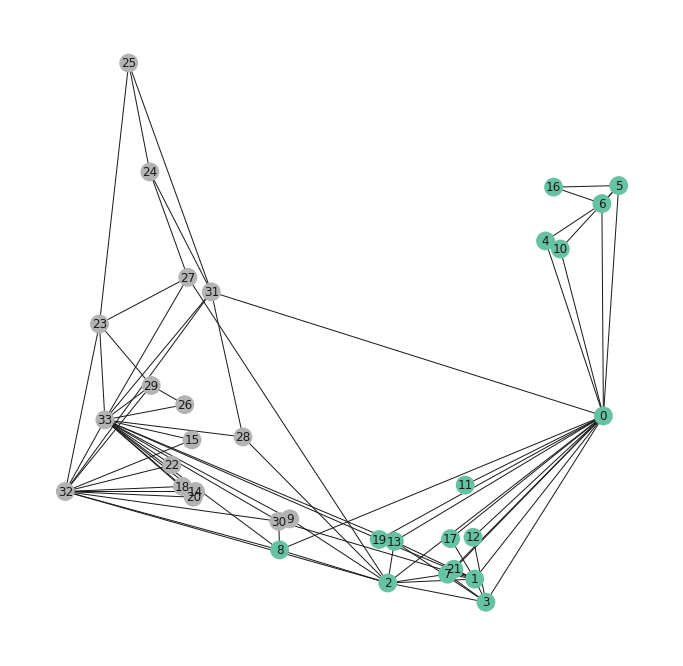

In [149]:
plot_graph(g, original_comms, pos=pca);

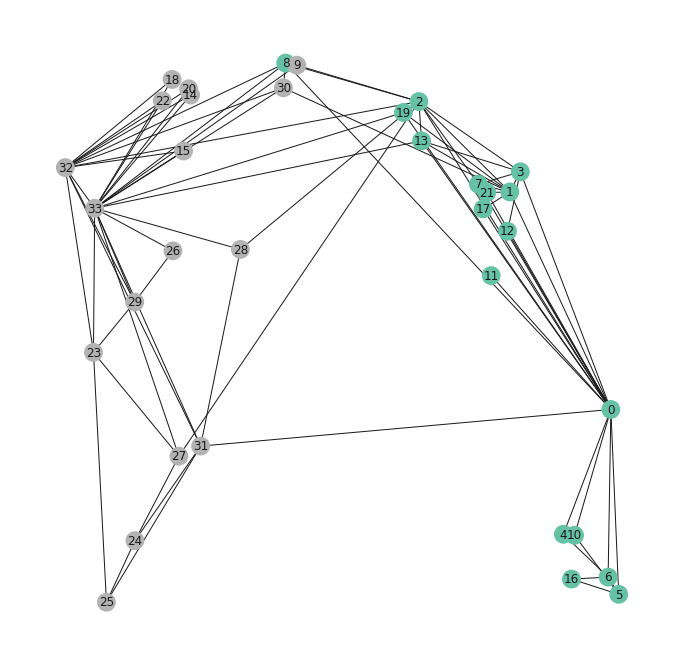

In [150]:
plot_graph(g, original_comms, pos=tsne);